<a href="https://colab.research.google.com/github/ebunalabiTH/EA_assignment_3_Fall2023_org/blob/main/EA_assignment_3_Fall2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGS 108 Fall 2022 Assignment 3**

*Due Oct 13th at 11:59PM on Github*

**Instructors:** George Cybenko

**TAs:** Ganesh Rohit Nirogi, Diksha Bubna, Sunishka Jain, Kushagra Rawat


---

## **Rules and Requirements**


1.   You are only allowed to use Python packages that are explicity imported in
the assignment notebook or are standard (bultin) python libraries like random, os, sys, etc, (Standard Bultin Python libraries will have a Python.org documentation). For this assignment you may use:
  *   [numpy](https://numpy.org/doc/stable/)
  *   [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  *   [scikit-learn](https://scikit-learn.org/stable/)
  *   [matplotlib](https://matplotlib.org/)
  *   [tensorflow](https://www.tensorflow.org/)

2.   All code must be fit into the designated code or text blocks in the assignment notebook. They are indentified by a **TODO** qualifier.

3. For analytical questions that don't require code, type your answer cleanly in Markdown. For help, see the [Google Colab Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

---


In [153]:
''' Import Statements '''
import os
import csv
import json
import pickle
import tqdm
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
from PIL import Image
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


# Data Loading
In this assignment we will be using the Yoga Postures Dataset from [Kaggle](https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset) and will use the following code blocks to download the dataset directly to your Google Drive.

## Creating a Kaggle API Token
First we will need to download an API token from Kaggle in order to download the dataset, so our first step is to create a Kaggle account if you don't already have one.
1. Create a Kaggle account by following the sign up instructions [here](https://www.kaggle.com/).
2. Log into your Kaggle account and click your account icon on the upper righthand side.
3. Then select **Account** from the dropdown/sidebar menu.
4. Scroll down to the **API** section and select **Create New API Token**.
5. This will download a JSON file called kaggle.json to your Downloads folder on your computer.
6. Now run the following code block and when the **Browse** button appears, click it and select that kaggle.json file.

In [ ]:
# Run this code block after creating a Kaggle API token as instructed above.
! pip install -q kaggle
from google.colab import files

# Will ask you to upload kaggle.json file and remove any old ones.
if os.path.exists('kaggle.json'):
  os.remove('kaggle.json')
files.upload()

# Will create the appropriate directory structure
if not os.path.exists('/root/.kaggle'):
  ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Downloading the Dataset

7. Now we have downloaded our Kaggle credentials we can now download the Yoga Postures Dataset (or any other Kaggle dataset for that matter) directly into our Google Drive.

In [ ]:
# Will ensure a train directory exists in your home and will create if it doesn't exist.
if not os.path.exists('train'):
  os.mkdir('train')
# Will download the yoga postures dataset zip file if it does not exist in the train directory.
if not os.path.exists('train/yoga-posture-dataset.zip'):
  ! kaggle datasets download -p train tr1gg3rtrash/yoga-posture-dataset
# Will check to see if the yoga postures zip file has been unzipped and will unzip the file if not.
if not os.path.exists('train/Poses.json'):
  ! unzip train/yoga-posture-dataset.zip -d train

# To remove train folder and redownload uncomment the code below
#!rm -rf train

 98% 439M/447M [00:03<00:00, 108MB/s]
100% 447M/447M [00:03<00:00, 140MB/s]
Archive:  train/yoga-posture-dataset.zip
  inflating: train/Adho Mukha Svanasana/File1.png  
  inflating: train/Adho Mukha Svanasana/File10.png  
  inflating: train/Adho Mukha Svanasana/File11.png  
  inflating: train/Adho Mukha Svanasana/File12.png  
  inflating: train/Adho Mukha Svanasana/File13.png  
  inflating: train/Adho Mukha Svanasana/File14.png  
  inflating: train/Adho Mukha Svanasana/File15.png  
  inflating: train/Adho Mukha Svanasana/File16.png  
  inflating: train/Adho Mukha Svanasana/File17.png  
  inflating: train/Adho Mukha Svanasana/File18.png  
  inflating: train/Adho Mukha Svanasana/File19.png  
  inflating: train/Adho Mukha Svanasana/File2.png  
  inflating: train/Adho Mukha Svanasana/File20.png  
  inflating: train/Adho Mukha Svanasana/File21.png  
  inflating: train/Adho Mukha Svanasana/File22.png  
  inflating: train/Adho Mukha Svanasana/File23.png  
  inflating: train/Adho Mukha Svanasa

## Viewing the Dataset Metadata
Now let's inspect the dataset metadata, i.e. the information about each of the training examples, which is located in the Poses.json file.

In [ ]:
# Let's load the yoga postures metadata
import json
with open('train/Poses.json', 'r') as metafile:
  metadata = json.load(metafile)
metadata = pd.DataFrame.from_dict(metadata['Poses'])
metadata.head()

,id,sanskrit_name,english_name,img_url
0,1,Navasana,Boat,https://www.dropbox.com/s/4m64ztxkj8a4dab/boat...
1,2,Ardha Navasana,Half-Boat,https://www.dropbox.com/s/1nx0r94msxjwvyp/boat...
2,3,Dhanurasana,Bow,https://www.dropbox.com/s/wizj5kwxvez4c0a/bow....
3,4,Setu Bandha Sarvangasana,Bridge,https://www.dropbox.com/s/f1w64ybg4sn8ejt/brid...
4,5,Baddha Konasana,Butterfly,https://www.dropbox.com/s/3h2pts6xbn28dh7/butt...


In [ ]:
#number of items in train data
# Specify the path to the folder you want to count files in
folder_path = 'train'
# Initialize a count for files
file_count = 0
# Use a list comprehension to count subfolders
subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
# Get the count of subfolders
num_subfolders = len(subfolders)

print(f"The folder '{folder_path}' contains {num_subfolders} subfolders.")

The folder 'train' contains 47 subfolders.


## Pre-Problem: Segmenting Out the Test Data and Copying to Google Drive
A part of this homework will be a competition. Included in your assignment github repo, there is a file called **test_images.csv**. This file holds all of the image paths that you are **NOT** allowed to use during *training*. Therefore, what we are going to do in this pre-problem is remove all the testing images from your train data folder. *Hint:* You naturally are still allowed/should use the test data to evaluate your model moving foward, you're just not allowed to use these images during training.

### Task 1
Using the code available in the Data loading section as a reference, write a command using the "!" colab operator to create a new directory called **test**.

In [ ]:
#TODO: Write one line of code to make a new directory called test (You might need to refresh your files view to see the change)
! mkdir test

### Task 2
Upload your **test_images.csv** file by running the following code block.

In [ ]:
files.upload()

Saving test_images.csv to test_images.csv


{'test_images.csv': b'Virabhadrasana Two/File41.png\r\nVirabhadrasana Two/File15.png\r\nVirabhadrasana Two/File49.png\r\nVirabhadrasana Two/File36.png\r\nVirabhadrasana Two/File29.png\r\nVirabhadrasana Two/File34.png\r\nVirabhadrasana Two/File14.png\r\nVirabhadrasana Two/File61.jpeg\r\nVirabhadrasana Two/File25.png\r\nVirabhadrasana Two/File28.png\r\nVirabhadrasana Two/File44.png\r\nVirabhadrasana Two/File13.png\r\nUpavistha Konasana/File8.jpeg\r\nUpavistha Konasana/File3.jpeg\r\nUpavistha Konasana/File6.jpeg\r\nSetu Bandha Sarvangasana/File65.jpeg\r\nSetu Bandha Sarvangasana/File60.jpg\r\nSetu Bandha Sarvangasana/File41.png\r\nSetu Bandha Sarvangasana/File50.jpg\r\nSetu Bandha Sarvangasana/File6.png\r\nSetu Bandha Sarvangasana/File23.png\r\nSetu Bandha Sarvangasana/File13.png\r\nSetu Bandha Sarvangasana/File48.jpg\r\nSetu Bandha Sarvangasana/File12.png\r\nSetu Bandha Sarvangasana/File15.png\r\nSetu Bandha Sarvangasana/File68.jpeg\r\nSetu Bandha Sarvangasana/File17.png\r\nSetu Bandha S

### Task 3
Now let's write some code to copy over all these test images into the test folder we created as well as removing them from the train folder.

In [ ]:
# First let's load the test_images.csv file
with open('test_images.csv', 'r') as f_:
  reader = csv.reader(f_)
  test_image_paths = []
  for row in reader:
    test_image_paths.append(row[0])

In [ ]:
test_image_paths

['Virabhadrasana Two/File41.png',
 'Virabhadrasana Two/File15.png',
 'Virabhadrasana Two/File49.png',
 'Virabhadrasana Two/File36.png',
 'Virabhadrasana Two/File29.png',
 'Virabhadrasana Two/File34.png',
 'Virabhadrasana Two/File14.png',
 'Virabhadrasana Two/File61.jpeg',
 'Virabhadrasana Two/File25.png',
 'Virabhadrasana Two/File28.png',
 'Virabhadrasana Two/File44.png',
 'Virabhadrasana Two/File13.png',
 'Upavistha Konasana/File8.jpeg',
 'Upavistha Konasana/File3.jpeg',
 'Upavistha Konasana/File6.jpeg',
 'Setu Bandha Sarvangasana/File65.jpeg',
 'Setu Bandha Sarvangasana/File60.jpg',
 'Setu Bandha Sarvangasana/File41.png',
 'Setu Bandha Sarvangasana/File50.jpg',
 'Setu Bandha Sarvangasana/File6.png',
 'Setu Bandha Sarvangasana/File23.png',
 'Setu Bandha Sarvangasana/File13.png',
 'Setu Bandha Sarvangasana/File48.jpg',
 'Setu Bandha Sarvangasana/File12.png',
 'Setu Bandha Sarvangasana/File15.png',
 'Setu Bandha Sarvangasana/File68.jpeg',
 'Setu Bandha Sarvangasana/File17.png',
 'Setu B

In [ ]:
# Add "train/" to the start of each item
modified_items = ["'"+'/content/train/' + test_path + "'" for test_path in test_image_paths]

# Print the modified list
for test_path in modified_items:
    print(test_path)

'/content/train/Virabhadrasana Two/File41.png'
'/content/train/Virabhadrasana Two/File15.png'
'/content/train/Virabhadrasana Two/File49.png'
'/content/train/Virabhadrasana Two/File36.png'
'/content/train/Virabhadrasana Two/File29.png'
'/content/train/Virabhadrasana Two/File34.png'
'/content/train/Virabhadrasana Two/File14.png'
'/content/train/Virabhadrasana Two/File61.jpeg'
'/content/train/Virabhadrasana Two/File25.png'
'/content/train/Virabhadrasana Two/File28.png'
'/content/train/Virabhadrasana Two/File44.png'
'/content/train/Virabhadrasana Two/File13.png'
'/content/train/Upavistha Konasana/File8.jpeg'
'/content/train/Upavistha Konasana/File3.jpeg'
'/content/train/Upavistha Konasana/File6.jpeg'
'/content/train/Setu Bandha Sarvangasana/File65.jpeg'
'/content/train/Setu Bandha Sarvangasana/File60.jpg'
'/content/train/Setu Bandha Sarvangasana/File41.png'
'/content/train/Setu Bandha Sarvangasana/File50.jpg'
'/content/train/Setu Bandha Sarvangasana/File6.png'
'/content/train/Setu Bandha S

In [ ]:
test_image_paths_mod = modified_items

In [ ]:
#create all folder paths in the test file
main_folder = "/content/train"

# Using a list comprehension to create a list of subfolders
subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

# Printlist of subfolders
print("Subfolders in", main_folder, "are:")
for folder in subfolders:
    print(folder)

Subfolders in /content/train are:
Navasana
Alanasana
Hanumanasana
Salamba Bhujangasana
Padmasana
Ashta Chandrasana
Malasana
Ardha Matsyendrasana
Setu Bandha Sarvangasana
Ustrasana
Vasisthasana
Ardha Navasana
Salamba Sarvangasana
Garudasana
Utkatasana
Uttanasana
Virabhadrasana One
Adho Mukha Vrksasana
Bitilasana
Virabhadrasana Three
Ardha Chandrasana
Dhanurasana
Camatkarasana
Balasana
Urdhva Mukha Svsnssana
Trikonasana
Adho Mukha Svanasana
Eka Pada Rajakapotasana
Utthita Parsvakonasana
Ardha Pincha Mayurasana
Phalakasana
Paschimottanasana
Marjaryasana
Bakasana
Vrksasana
Urdhva Dhanurasana
Baddha Konasana
Parsva Virabhadrasana
Anjaneyasana
Halasana
Parsvottanasana
Utthita Hasta Padangusthasana
Pincha Mayurasana
Virabhadrasana Two
Supta Kapotasana
Upavistha Konasana
Sivasana


In [ ]:
# Specify the base directory where you want to create new folders
base_directory = "/content/test"

# List of new folder names you want to create
new_folders =  subfolders

# Create the new folders
for folder_name in new_folders:
    folder_path = os.path.join(base_directory, folder_name)

    # Check if the folder already exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

Created folder: /content/test/Navasana
Created folder: /content/test/Alanasana
Created folder: /content/test/Hanumanasana
Created folder: /content/test/Salamba Bhujangasana
Created folder: /content/test/Padmasana
Created folder: /content/test/Ashta Chandrasana
Created folder: /content/test/Malasana
Created folder: /content/test/Ardha Matsyendrasana
Created folder: /content/test/Setu Bandha Sarvangasana
Created folder: /content/test/Ustrasana
Created folder: /content/test/Vasisthasana
Created folder: /content/test/Ardha Navasana
Created folder: /content/test/Salamba Sarvangasana
Created folder: /content/test/Garudasana
Created folder: /content/test/Utkatasana
Created folder: /content/test/Uttanasana
Created folder: /content/test/Virabhadrasana One
Created folder: /content/test/Adho Mukha Vrksasana
Created folder: /content/test/Bitilasana
Created folder: /content/test/Virabhadrasana Three
Created folder: /content/test/Ardha Chandrasana
Created folder: /content/test/Dhanurasana
Created fo

In [ ]:
# TODO: Now using these test image paths, copy over these files to the test directory and remove them from the train directory


# Destination test folder
test_folder = "/content/test"

# Ensure the test folder exists
if not os.path.exists(test_folder):
    os.makedirs(test_folder)


In [ ]:
for test_path in modified_items:
  print (test_path)

'/content/train/Virabhadrasana Two/File41.png'
'/content/train/Virabhadrasana Two/File15.png'
'/content/train/Virabhadrasana Two/File49.png'
'/content/train/Virabhadrasana Two/File36.png'
'/content/train/Virabhadrasana Two/File29.png'
'/content/train/Virabhadrasana Two/File34.png'
'/content/train/Virabhadrasana Two/File14.png'
'/content/train/Virabhadrasana Two/File61.jpeg'
'/content/train/Virabhadrasana Two/File25.png'
'/content/train/Virabhadrasana Two/File28.png'
'/content/train/Virabhadrasana Two/File44.png'
'/content/train/Virabhadrasana Two/File13.png'
'/content/train/Upavistha Konasana/File8.jpeg'
'/content/train/Upavistha Konasana/File3.jpeg'
'/content/train/Upavistha Konasana/File6.jpeg'
'/content/train/Setu Bandha Sarvangasana/File65.jpeg'
'/content/train/Setu Bandha Sarvangasana/File60.jpg'
'/content/train/Setu Bandha Sarvangasana/File41.png'
'/content/train/Setu Bandha Sarvangasana/File50.jpg'
'/content/train/Setu Bandha Sarvangasana/File6.png'
'/content/train/Setu Bandha S

In [ ]:
tst = '/content/train/Adho Mukha Svanasana/File13.png'
parts = tst.split('/', 3)
parts[2]

'train'

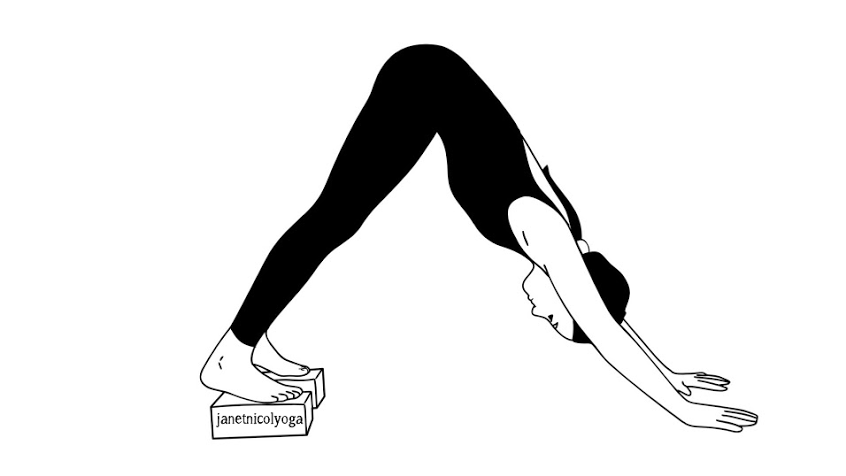

In [ ]:
image = Image.open('/content/train/Adho Mukha Svanasana/File13.png')
image

In [ ]:
tst = '/content/train/Garudasana/File41.png'
parts = tst.split('/',3)
shutil.move( tst, '/content/test/' + parts[3])

'/content/test/Garudasana/File41.png'

In [ ]:
modified_items

["'/content/train/Virabhadrasana Two/File41.png'",
 "'/content/train/Virabhadrasana Two/File15.png'",
 "'/content/train/Virabhadrasana Two/File49.png'",
 "'/content/train/Virabhadrasana Two/File36.png'",
 "'/content/train/Virabhadrasana Two/File29.png'",
 "'/content/train/Virabhadrasana Two/File34.png'",
 "'/content/train/Virabhadrasana Two/File14.png'",
 "'/content/train/Virabhadrasana Two/File61.jpeg'",
 "'/content/train/Virabhadrasana Two/File25.png'",
 "'/content/train/Virabhadrasana Two/File28.png'",
 "'/content/train/Virabhadrasana Two/File44.png'",
 "'/content/train/Virabhadrasana Two/File13.png'",
 "'/content/train/Upavistha Konasana/File8.jpeg'",
 "'/content/train/Upavistha Konasana/File3.jpeg'",
 "'/content/train/Upavistha Konasana/File6.jpeg'",
 "'/content/train/Setu Bandha Sarvangasana/File65.jpeg'",
 "'/content/train/Setu Bandha Sarvangasana/File60.jpg'",
 "'/content/train/Setu Bandha Sarvangasana/File41.png'",
 "'/content/train/Setu Bandha Sarvangasana/File50.jpg'",
 "'/c

In [ ]:
for test_path in modified_items:
  # Do something... (hint see cp and rm commands using the colab terminal, i.e. the "!" operator)
  parts = test_path.split('/',3)
  new_destination = os.path.join('/content/test', parts[3])
  try:
      # Move the file from the training folder to the test folder
      shutil.move(test_path[1:-1], new_destination)
      print(f"Moved {test_path} to the test folder.")
  except FileNotFoundError:
      print(f"File not found: {test_path}")
  except Exception as e:
      print(f"Error moving {test_path}: {str(e)}")

Moved '/content/train/Virabhadrasana Two/File41.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File15.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File49.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File36.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File29.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File34.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File14.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File61.jpeg' to the test folder.
Moved '/content/train/Virabhadrasana Two/File25.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File28.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File44.png' to the test folder.
Moved '/content/train/Virabhadrasana Two/File13.png' to the test folder.
Moved '/content/train/Upavistha Konasana/File8.jpeg' to the test folder.
Moved '/content/train/Upavistha Konasana/File3.jpe

In [ ]:
for test_path in modified_items:
  test_path = test_path[1:-1]
  #print (test_path)
  print(os.path.exists(test_path))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

### Task 4
Now that we have our test and training sets setup, let's copy them over to our Google Drive so that we don't have to run this pipeline again.

1. Mount your Google Drive in colab in the standard way by running the following code block.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Now run the following command to copy over the training and test data to your desired location. Remember this location so you don't have to run this data loading section everytime you want to work on your homework.

In [ ]:
# DESIRED GOOGLE DRIVE DIRECTORY (CHANGE ME)
DESIRED_GOOGLE_DRIVE_DIR = '/content/drive/MyDrive/data/yoga-poses'

# Makes the desired directory. If you get an error then the directory likely already exists, so comment out this line.
! mkdir -p $DESIRED_GOOGLE_DRIVE_DIR

# Command to copy over all test and train data to desired google drive path
! cp -r train $DESIRED_GOOGLE_DRIVE_DIR
! cp -r test $DESIRED_GOOGLE_DRIVE_DIR

cp: cannot stat 'train': No such file or directory
cp: cannot stat 'test': No such file or directory


# Problem 1: Support Vector Machine Classification
In this problem, you will be building support vector machines for some cool classification tasks.

## Task 1: Synthetic Data
 In this part we will be exploring the *circles* dataset. This dataset is avialable as a pickle file labeled *circles.pk* in your assignment repository under datasets. In this dataset you will have an $X$ array of 2 dimensional samples of the form $(x_1, x_2)$ and a $y$ array of each samples associated label.

### Part A
Upload this dataset to your Google Drive and load the dataset into memory using the pickle module (*Hint: Refer to previous assignments to figure out how to do this*). Go through the circles dataset and create a scatterplot of the circles data using the y label as each sample's color to designate their respective class.

In [249]:
# TODO: Change me
CIRCLES_DATASET_PATH = '/content/drive/MyDrive/data/circles/circles.pk'

# TODO: Load the dataset using pickle load
with open(CIRCLES_DATASET_PATH, 'rb') as circles_file:
  # TODO: Load here...
  circles = pickle.load(circles_file)

print("Dataset loaded successfully:", circles)

Dataset loaded successfully: (array([[ 0.23733469,  1.17806013],
       [-0.1370839 ,  0.03550885],
       [ 1.16402936, -0.02264795],
       ...,
       [-0.13255357, -0.25989146],
       [-0.24307968,  0.01000444],
       [ 0.15166816,  0.93479069]]), array([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 

In [ ]:
len(circles)

2

In [250]:
x = circles[0]
y = circles[1]

In [251]:
print (x)

[[ 0.23733469  1.17806013]
 [-0.1370839   0.03550885]
 [ 1.16402936 -0.02264795]
 ...
 [-0.13255357 -0.25989146]
 [-0.24307968  0.01000444]
 [ 0.15166816  0.93479069]]


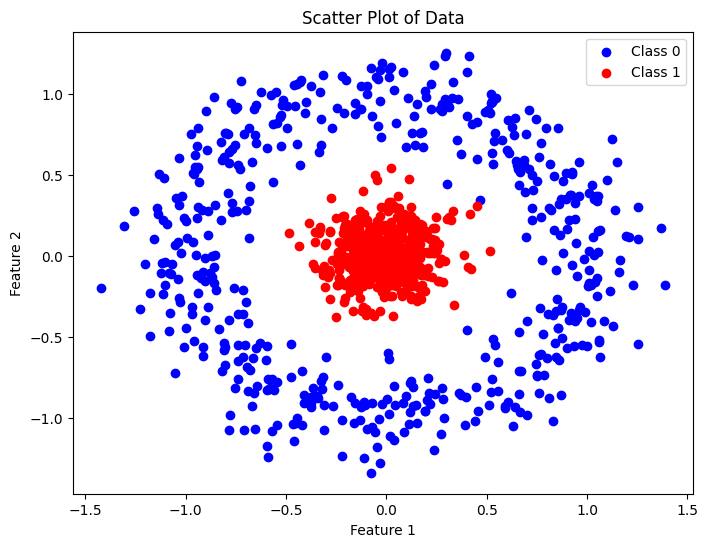

In [252]:

# TODO: Graph the data
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], label='Class 0', c='blue')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], label='Class 1', c='red')
plt.title('Scatter Plot of Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()





### Part B
Is this dataset linearly seperable? Explain why or why not?

**TODO:** No its not, this is because class 0 and class 1 elements can not be seperated by a straight line.

### Part C
Can you think of a transformation that can be applied to this dataset that could make it linearly seperable? If so, define what these transformation function(s) might look like, and if not explain why. *Hint: Think of a higher dimensional space.*

**TODO:** One commonly used technique is to use a radial basis function (RBF) kernel, which implicitly maps the data to a higher-dimensional space without having to explicitly compute the transformation.

In the case of an RBF kernel, the transformation can be thought of as mapping each data point to an infinite-dimensional space.

### Part D
If you where able to find a transformation in (Part C), create a suitable graph showing that the dataset is linearly seperable in this new feature space.

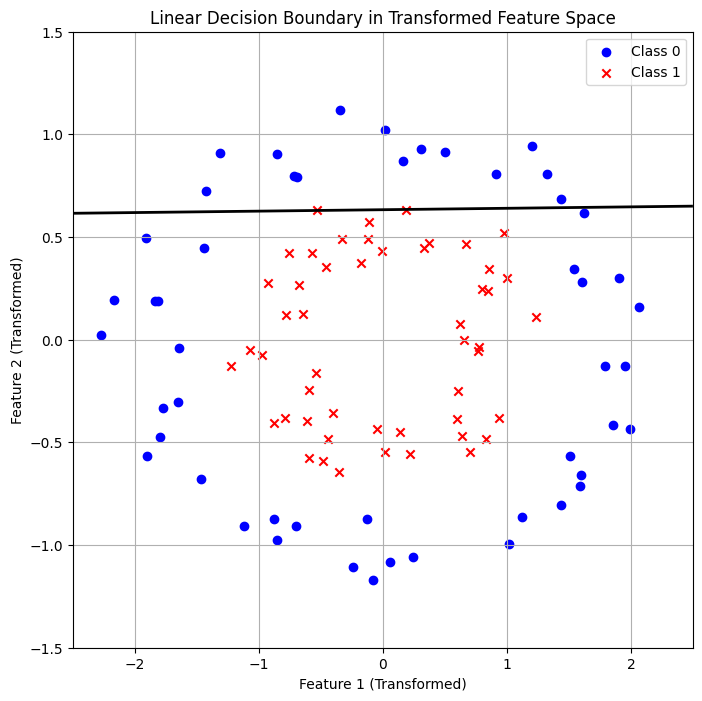

In [261]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Generate the circles dataset
data, labels = make_circles(n_samples=100, factor=0.5, noise=0.1)

# Create a simple transformation to make it linearly separable (for demonstration)
# This transformation won't make it truly linearly separable, but it's for visualization purposes
data_transformed = data * np.array([2, 1])

# Fit a linear SVM classifier to the transformed data
clf = SVC(kernel='linear')
clf.fit(data_transformed, labels)

# Create a grid to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 500), np.linspace(-1.5, 1.5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create a scatterplot with the decision boundary
plt.figure(figsize=(8, 8))
plt.scatter(data_transformed[labels == 0][:, 0], data_transformed[labels == 0][:, 1], c='b', label='Class 0', marker='o')
plt.scatter(data_transformed[labels == 1][:, 0], data_transformed[labels == 1][:, 1], c='r', label='Class 1', marker='x')

# Plot the decision boundary
plt.contour(xx, yy, Z, levels=[1], linewidths=2, colors='k')

plt.xlabel('Feature 1 (Transformed)')
plt.ylabel('Feature 2 (Transformed)')
plt.title('Linear Decision Boundary in Transformed Feature Space')
plt.legend()
plt.grid(True)

plt.show()


## Task 2: Yoga Pose Classification
What we accomplished in Part 1 is known as the kernel trick for SVMs. Now let's focus on how we can use this idea to accomplish non-linear classification on a real world dataset. In this next part and throughout the remainder of the assignment we will be using a yoga postures dataset. These images are PNG and JPEG images with many pixels.

### Part A
You have been given a number of code skeletons throughout the course all of which load and preprocess the data for you. In this excerise tho, we will be doing the data loading manually as it is an important skill to learn. Write some code that will walk through the *Yoga Postures Dataset* directory structure and build a single large numpy array (Make sure to resize the image to something like (28, 28) or (32, 32) for the SVM and at minimum (71, 71) for the deep learning tasks) *Hint: You have been provided with a basic skeleton, study the operations of the code and finish the script.*

In [212]:
# TODO: Change Me
PATH_TO_YOGA_TRAIN_DATA = '/content/drive/MyDrive/data/yoga-poses/train'
PATH_TO_YOGA_TEST_DATA = '/content/drive/MyDrive/data/yoga-poses/test'

# The dimensions of the resized image
RESIZE = (71,71)
# A map from integer ids to yoga pose categories (strings)
pose_map = {}
# The data lists that we will be filling in.
X, y = [], []

# Let's start our for loop (Just using tqdm to give us a pretty progress bar).
class_id = 0
for subfold in tqdm.tqdm(os.listdir(PATH_TO_YOGA_TRAIN_DATA), desc='Processing training images', leave=False):
  if os.path.isdir(os.path.join(PATH_TO_YOGA_TRAIN_DATA, subfold)):
    if subfold == 'Utkatasana':
            # Skip the .ipynb_checkpoints directory
            continue
    # We have found image class folder so let's extract all example data
    pose_map[class_id] = subfold
    class_id += 1

    for img_name in os.listdir(os.path.join(PATH_TO_YOGA_TRAIN_DATA, subfold)):
      #TODO: Preprocess and load image

      image_path = os.path.join(PATH_TO_YOGA_TRAIN_DATA, subfold, img_name)
      # Load the image with PIL
      image = Image.open(image_path)

      #HINT: PNGs will have 4 channels and JPEGs will have 3 (THIS WILL CAUSE ISSUES!).
      # Try to figure out what to do with this 4th channel. It could be as simple as deleting it...


      # Resize the image
      image = image.resize((71, 71))

      # Convert to RGB to handle 4-channel PNG images
      if image.mode == 'RGBA':
          image = image.convert('RGB')

      # Convert to NumPy array and ensure consistent shape
      image_array = np.array(image)
      if image_array.shape != (71, 71, 3):
          # Handle cases where images have the wrong shape
          # You may choose to skip or preprocess these images differently
          continue

      X.append(image_array)  # Convert to NumPy array
      y.append(class_id)  # Append class ID

X_train = np.array(X)
y_train = np.array(y)

In [68]:
import os

# Define the directory where you want to delete .ipynb_checkpoints
target_directory = '/content/drive/MyDrive/data/yoga-poses/test'

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(target_directory):
    for directory in dirs:
        if directory == '.ipynb_checkpoints':
            directory_path = os.path.join(root, directory)
            # Delete the .ipynb_checkpoints directory
            try:
                os.rmdir(directory_path)
                print(f"Deleted: {directory_path}")
            except OSError as e:
                print(f"Error deleting {directory_path}: {e}")


Deleted: /content/drive/MyDrive/data/yoga-poses/test/Alanasana/.ipynb_checkpoints
Deleted: /content/drive/MyDrive/data/yoga-poses/test/Adho Mukha Svanasana/.ipynb_checkpoints
Deleted: /content/drive/MyDrive/data/yoga-poses/test/Anjaneyasana/.ipynb_checkpoints
Deleted: /content/drive/MyDrive/data/yoga-poses/test/Ardha Chandrasana/.ipynb_checkpoints
Deleted: /content/drive/MyDrive/data/yoga-poses/test/Adho Mukha Vrksasana/.ipynb_checkpoints


In [213]:
# Let's load in the training data as well using the same methodology but with the pose_map built during the training data collection.
pose_map_reverse = {pose: class_id for class_id, pose in pose_map.items()}
X, y = [], []
notskipped=0
for subfold in tqdm.tqdm(os.listdir(PATH_TO_YOGA_TEST_DATA), desc='Processing test images', leave=False):
  if os.path.isdir(os.path.join(PATH_TO_YOGA_TEST_DATA, subfold)):
    if subfold == 'Utkatasana':
            # Skip the .ipynb_checkpoints directory
            continue

    # We have found image class folder so let's extract all example data
    class_id = pose_map_reverse[subfold]

    for img_name in os.listdir(os.path.join(PATH_TO_YOGA_TEST_DATA, subfold)):




      #TODO: Preprocess and load image
      image_path = os.path.join(PATH_TO_YOGA_TEST_DATA, subfold, img_name)
      # Load the image with PIL
      image = Image.open(image_path)



      #HINT: PNGs will have 4 channels and JPEGs will have 3 (THIS WILL CAUSE ISSUES!).
      # Try to figure out what to do with this 4th channel. It could be as simple as deleting it...
      #class_id += 1

      # Resize the image
      image = image.resize((71, 71))


      # Convert to RGB to handle 4-channel PNG images
      if image.mode == 'RGBA':
          image = image.convert('RGB')

      # Convert to NumPy array and ensure consistent shape
      image_array = np.array(image)

      if image_array.shape != (71, 71, 3):

          # Handle cases where images have the wrong shape
          # You may choose to skip or preprocess these images differently
          continue

      X.append(image_array)  # Convert to NumPy array
      y.append(class_id)  # Append class ID

X_test = np.array(X)
y_test = np.array(y)

### Part B
Implement a SVM classifer using sklearn and report your classification results on the testing dataset. Make sure to flatten your X data from the three channels before passing into the SVM.

In [172]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Flatten X_test similarly
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_flattened, y_train, test_size=0.2, random_state=42)

# Create and train an SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Make predictions on the testing dataset
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           1       0.21      0.67      0.32         9
           2       0.25      0.18      0.21        11
           3       0.00      0.00      0.00         2
           4       0.25      0.25      0.25         8
           5       0.25      0.55      0.34        11
           6       0.41      0.47      0.44        19
           7       0.00      0.00      0.00         3
           8       0.50      0.33      0.40         6
           9       0.00      0.00      0.00         2
          10       0.17      0.15      0.16        13
          11       0.56      0.26      0.36        19
          12       0.14      0.18      0.16        11
          13       0.62      0.72      0.67        18
          14       0.36      0.44      0.40         9
          15       1.00      0.12      0.22         8
          16       0.00      0.00      0.00         5
          17       0.50      0.80      0.62        10
          18       0.60    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Accuracy: 40%**

In [173]:
Xtr_flat = X_train.reshape(X_train.shape[0], -1)

In [176]:
Xts_flat = X_test.reshape(X_test.shape[0], -1)

In [178]:
y_test.shape

(427,)

# Problem 2: Introduction to TensorFlow
In this problem, we will start working in tensorflow to build deep learning systems starting with fully-connected (FC) and convolutional (CNN) neural networks. We will focus on using the yoga postures dataset, ending this problem with a small class competition that may come with a prize...

## Task 1: A Fully-Connected Neural Network

### Part A
Using the yoga postures dataset, build a [tensorflow Data Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that is shuffled with a batch size of 10. *Hint: We did this in class.*

In [179]:
# Create a TensorFlow Dataset from your data
dataset = tf.data.Dataset.from_tensor_slices((Xtr_flat, y_train))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(Xtr_flat))

# Set the batch size
batch_size = 10
dataset = dataset.batch(batch_size)

# (Optional) Prefetch for improved performance
training_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now, you can iterate through the dataset using a loop
for batch in training_dataset:
    # Process each batch as needed
    images, labels = batch
    # Your training step goes here

In [180]:
# Create a TensorFlow Dataset from your data
dataset = tf.data.Dataset.from_tensor_slices((Xts_flat, y_test))

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=len(Xts_flat))

# Set the batch size
batch_size = 10
dataset = dataset.batch(batch_size)

# (Optional) Prefetch for improved performance
testing_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Now, you can iterate through the dataset using a loop
for batch in testing_dataset:
    # Process each batch as needed
    images, labels = batch
    # Your training step goes here

### Part B
Build a two layer fully connected neural network of any size with a ReLu activation function and a final softmax layer.

In [223]:
# Create a Keras model
model = keras.Sequential([
    layers.Flatten(input_shape=(71, 71, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # 'num_classes' is the number of classes in your problem
])

### Part C
Compile your model with an appropriate loss function and optimizer. Briefly describe your choices.

In [198]:
#TODO: Your code goes here.
# Compile the model
model.compile(optimizer='adam',  # Optimizer
              loss='sparse_categorical_crossentropy',  # Loss function
              metrics=['accuracy'])  # Additional metric for monitoring
# Optionally, you can print a summary of the model to see its architecture
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 71, 71, 128)       512       
                                                                 
 dense_61 (Dense)            (None, 71, 71, 64)        8256      
                                                                 
 dense_62 (Dense)            (None, 71, 71, 47)        3055      
                                                                 
Total params: 11823 (46.18 KB)
Trainable params: 11823 (46.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [208]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



1. **Optimizer**: `'adam'`
   - **Brief Description**: Adam (short for Adaptive Moment Estimation) is an adaptive optimization algorithm that combines elements of both momentum and RMSprop. It's widely used in deep learning because of its efficiency and effectiveness in training neural networks. Adam adapts the learning rates for each parameter during training, making it suitable for a wide range of problems.

2. **Loss Function**: `'sparse_categorical_crossentropy'`
   - **Brief Description**: Sparse categorical cross-entropy is a common choice for multi-class classification problems. It's suitable when the target labels are integers representing class indices, and it measures the dissimilarity between the predicted class probabilities and the true class labels. This loss function encourages the model to output high probabilities for the correct classes and low probabilities for the incorrect classes.


### Part D
Train your model on the yoga pose training dataset. And report your accuracy on the testing dataset.

In [215]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)

In [220]:
X_train_.shape

(2131, 71, 71, 3)

In [221]:
#X_train_reshaped = X_train_flat.reshape(-1, 71, 71, 3)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming X_train_flat and y_train are your training data
# Train the model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=batch_size)


Epoch 1/10
214/214 [==============================] - 2s 2ms/step - loss: 175.1571 - accuracy: 0.0230
Epoch 2/10
214/214 [==============================] - 1s 2ms/step - loss: 3.8426 - accuracy: 0.0263
Epoch 3/10
214/214 [==============================] - 1s 2ms/step - loss: 3.8202 - accuracy: 0.0338
Epoch 4/10
214/214 [==============================] - 1s 2ms/step - loss: 3.8045 - accuracy: 0.0357
Epoch 5/10
214/214 [==============================] - 1s 3ms/step - loss: 3.7920 - accuracy: 0.0328
Epoch 6/10
214/214 [==============================] - 1s 3ms/step - loss: 3.7819 - accuracy: 0.0361
Epoch 7/10
214/214 [==============================] - 1s 3ms/step - loss: 3.7722 - accuracy: 0.0357
Epoch 8/10
214/214 [==============================] - 1s 3ms/step - loss: 3.7864 - accuracy: 0.0305
Epoch 9/10
214/214 [==============================] - 1s 3ms/step - loss: 3.7771 - accuracy: 0.0310
Epoch 10/10
214/214 [==============================] - 1s 2ms/step - loss: 3.8012 - accuracy: 0.03

In [222]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


16/16 [==============================] - 0s 2ms/step - loss: 3.8937 - accuracy: 0.0240
Test accuracy: 0.023952096700668335


## Task 2: A Convolutional Neural Network
CNNs perform notoriously well on image classification tasks, so we will study a simple implementation of this network and let you guys compete to see who finds the best architecture.

### Part A: Vanilla CNN
Build, compile, and fit a CNN with the following network structure:
* A total of 3 convolutional segments consisting of:
  - A convolutional layer with "valid" padding and Relu activation and your choice of kernel size, number of filters and strides,
  - An average pooling layer,
* Then a fully connected layer with 128 neurons with ReLu activations.
* Then a fully connected layer with 64 neurons and ReLu activations.
* And ending with a softmax output layer.



In [224]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create the CNN model
model = models.Sequential()

# First convolutional segment
model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding="valid", activation='relu', input_shape=(71, 71, 3)))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

# Output layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',  # You can choose other optimizers
              loss='sparse_categorical_crossentropy',  # Use appropriate loss function
              metrics=['accuracy'])  # Additional metrics to monitor during training

# Now you can fit this model to your training data and evaluate it on the testing data


In [225]:
# Fit the model to your training data
model.fit(X_train, y_train, epochs=10)  # Adjust the number of epochs as needed

Epoch 1/10
67/67 [==============================] - 2s 4ms/step - loss: 107.4000 - accuracy: 0.0230
Epoch 2/10
67/67 [==============================] - 0s 3ms/step - loss: 3.5830 - accuracy: 0.1000
Epoch 3/10
67/67 [==============================] - 0s 3ms/step - loss: 2.9297 - accuracy: 0.2586
Epoch 4/10
67/67 [==============================] - 0s 3ms/step - loss: 2.1761 - accuracy: 0.4425
Epoch 5/10
67/67 [==============================] - 0s 3ms/step - loss: 1.4130 - accuracy: 0.6518
Epoch 6/10
67/67 [==============================] - 0s 3ms/step - loss: 0.8792 - accuracy: 0.7837
Epoch 7/10
67/67 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.8691
Epoch 8/10
67/67 [==============================] - 0s 3ms/step - loss: 0.4093 - accuracy: 0.9122
Epoch 9/10
67/67 [==============================] - 0s 3ms/step - loss: 0.2820 - accuracy: 0.9479
Epoch 10/10
67/67 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9718


In [226]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


16/16 [==============================] - 0s 4ms/step - loss: 14.3843 - accuracy: 0.0180
Test accuracy: 0.01796407252550125


### Part B: Transfer Learning
Now we are going to steal from a state-of-the-art [Xception](https://arxiv.org/abs/1610.02357) model. Luckily, tensorflow has this directly available to us and we are going to use transfer learning to tune this SoA model to our dataset. Therefore, run the following code block to build our base Xception model:

In [228]:
# I'll setup your base model for you.
from tensorflow.keras.applications import Xception

base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(71,71,3)
)
base_model.trainable=False

Now create a new model with this *base_model* as our first layer followed by:
* Global average pooling layer,
* A Dense layer with 256 neurons and ReLu activations,
* A 40% Dropout layer,
* A softmax output layer.

Then fit this model on 30 epochs.

In [235]:
y_train

array([ 1,  1,  1, ..., 46, 46, 46])

In [245]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create a base model
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(71, 71, 3)
)
base_model.trainable = False

# Create a new model
model = Sequential()

# Add the base model
model.add(base_model)

# Add global average pooling layer
model.add(GlobalAveragePooling2D())

# Add a Dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))

# Add a Dropout layer with 40% dropout rate
model.add(Dropout(0.4))

# Add the softmax output layer with the number of classes (46 in your case)
num_classes = 47
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on 30 epochs (adjust this as needed)
model.fit(X_train_preprocessed, y_train_one_hot, epochs=30, validation_data=(X_test_preprocessed, y_test_one_hot))


Epoch 1/30
67/67 [==============================] - 5s 29ms/step - loss: 6.6832 - accuracy: 0.0272 - val_loss: 3.8522 - val_accuracy: 0.0200
Epoch 2/30
67/67 [==============================] - 1s 13ms/step - loss: 3.8360 - accuracy: 0.0357 - val_loss: 3.8494 - val_accuracy: 0.0259
Epoch 3/30
67/67 [==============================] - 1s 13ms/step - loss: 3.8179 - accuracy: 0.0347 - val_loss: 3.8485 - val_accuracy: 0.0240
Epoch 4/30
67/67 [==============================] - 1s 13ms/step - loss: 3.8176 - accuracy: 0.0361 - val_loss: 3.8492 - val_accuracy: 0.0240
Epoch 5/30
67/67 [==============================] - 1s 13ms/step - loss: 3.8110 - accuracy: 0.0352 - val_loss: 3.8496 - val_accuracy: 0.0240
Epoch 6/30
67/67 [==============================] - 1s 13ms/step - loss: 3.8028 - accuracy: 0.0357 - val_loss: 3.8521 - val_accuracy: 0.0240
Epoch 7/30
67/67 [==============================] - 1s 13ms/step - loss: 3.7944 - accuracy: 0.0361 - val_loss: 3.8531 - val_accuracy: 0.0240
Epoch 8/30
67

In [243]:
# Resize images to (224, 224) and normalize pixel values
X_test_preprocessed = preprocess_input(X_test)

# Prepare the labels as one-hot encoded vectors if using categorical cross-entropy
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Now, you can use X_train_preprocessed as input to the model

In [244]:
# Resize images to (224, 224) and normalize pixel values
X_train_preprocessed = preprocess_input(X_train)

# Prepare the labels as one-hot encoded vectors if using categorical cross-entropy
y_train_one_hot = to_categorical(y_train, num_classes=47)

# Now, you can use X_train_preprocessed as input to the model

In [246]:
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_one_hot)
print("Test accuracy:", test_accuracy)


16/16 [==============================] - 0s 11ms/step - loss: 3.9155 - accuracy: 0.0020
Test accuracy: 0.0019960079807788134


### Part C: Build your Own Model
So know that you know the range of accuracies between poorly built models and state-of-the-art models like Xception, can you improve on them? Attempt to build your own deep neural network architecture and see if you can do better than the base CNN model presented above or better yet the Xception model we transfer learned. You may use any architecture or configuration you like.

In [107]:
#TODO: Build and train your custom model and evaluate on the test data.
# Define the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(71, 71, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(47, activation='softmax')  # Adjust the output units based on your task
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# You can adjust the number of epochs and batch size based on your dataset
epochs = 30
batch_size = 32




In [247]:
# Fit the model to your training data
model.fit(X_train_preprocessed, y_train_one_hot, batch_size=32)

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_one_hot)
print("Test accuracy:", test_accuracy)

16/16 [==============================] - 0s 10ms/step - loss: 3.9178 - accuracy: 0.0020
Test accuracy: 0.0019960079807788134


### Part D: Compete!
To enter the class competition for the best model save out your model as a H5 file and upload it to your assignment repo using the following code block.

In [248]:
#TODO: Save your tensorflow model with:
model.save('/content/drive/MyDrive/models/yoga-cnn.h5')
#TODO: Download your model from Google Drive and upload that saved file to your github assignment repo when you submit your assignment.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
